In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [45]:
import cairo
num_imgs = 500

img_size = 32
min_object_size = 4
max_object_size = 16
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size, 4), dtype=np.uint8)  # format: BGRA
shapes = np.zeros((num_imgs, num_objects), dtype=int)
num_shapes = 3
shape_labels = ['rectangle', 'circle', 'triangle']
colors = np.zeros((num_imgs, num_objects), dtype=int)
num_colors = 3
color_labels = ['r', 'g', 'b']

for i_img in range(num_imgs):
    surface = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_ARGB32, img_size, img_size)
    cr = cairo.Context(surface)

    # Fill background white.
    cr.set_source_rgb(1, 1, 1)
    cr.paint()
    
    # TODO: Try no overlap here.
    # Draw random shapes.
    for i_object in range(num_objects):
        shape = np.random.randint(num_shapes)
        shapes[i_img, i_object] = shape
        if shape == 0:  # rectangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            bboxes[i_img, i_object] = [x, y, w, h]
            cr.rectangle(x, y, w, h)          
        elif shape == 1:  # circle   
            r = 1 * np.random.randint(min_object_size, max_object_size)
            x = np.random.randint(r, img_size - r)
            y = np.random.randint(r, img_size - r)
            bboxes[i_img, i_object] = [x - r, y - r, 2 * r, 2 * r]
            cr.arc(x, y, r, 0, 2*np.pi)
        elif shape == 2:  # triangle
            w, h = np.random.randint(min_object_size, max_object_size, size=2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            bboxes[i_img, i_object] = [x, y, w, h]
            cr.move_to(x, y)
            cr.line_to(x+w, y)
            cr.line_to(x+w, y+h)
            cr.line_to(x, y)
            cr.close_path()
        
        # TODO: Introduce some variation to the colors by adding a small random offset to the rgb values.
        color = np.random.randint(num_colors)
        colors[i_img, i_object] = color
        max_offset = 0.3
        r_offset, g_offset, b_offset = max_offset * 2. * (np.random.rand(3) - 0.5)
        if color == 0:
            cr.set_source_rgb(1-max_offset+r_offset, 0+g_offset, 0+b_offset)
        elif color == 1:
            cr.set_source_rgb(0+r_offset, 1-max_offset+g_offset, 0+b_offset)
        elif color == 2:
            cr.set_source_rgb(0+r_offset, 0-max_offset+g_offset, 1+b_offset)
        cr.fill()
        
imgs = imgs[..., 2::-1]  # is BGRA, convert to RGB

# surface.write_to_png('imgs/{}.png'.format(i_img))
imgs.shape, bboxes.shape, shapes.shape, colors.shape

((500, 32, 32, 3), (500, 2, 4), (500, 2), (500, 2))

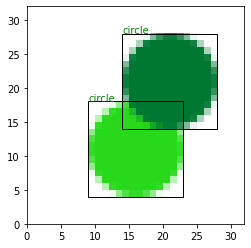

In [46]:
i = 5
plt.imshow(imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape, color in zip(bboxes[i], shapes[i], colors[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='k', fc='none'))
    plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.1), color=color_labels[color], clip_on=False)
# surface.write_to_png("circle.png")

In [ ]:
X = (imgs - 128.) / 255.
X.shape, np.mean(X), np.std(X)

In [ ]:

colors_onehot = np.zeros((num_imgs, num_objects, num_colors))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        colors_onehot[i_img, i_object, colors[i_img, i_object]] = 1

shapes_onehot = np.zeros((num_imgs, num_objects, num_shapes))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        shapes_onehot[i_img, i_object, shapes[i_img, i_object]] = 1
        
y = np.concatenate([bboxes / img_size, shapes_onehot, colors_onehot], axis=-1).reshape(num_imgs, -1)
y.shape, np.all(np.argmax(colors_onehot, axis=-1) == colors)

In [ ]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Activation,Conv2D,MaxPooling2D,Flatten
import matplotlib.pyplot as plt

In [ ]:
model = models.Sequential()

In [ ]:

model.add(layers.Conv2D(32, (6, 6), activation='relu', input_shape=X.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

In [ ]:
model.summary()

In [ ]:
model.add(layers.Flatten())
model.add(Dropout(0.4))
model.add(layers.Dense(256, activation='softmax'))
model.add(Dropout(0.4))
model.add(layers.Dense(y.shape[-1]))

In [ ]:
model.compile(optimizer='adadelta',
             loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=10)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten

# Activate GPU for this, otherwise the convnet will take forever to train with Theano.

# TODO: Make one run with very deep network (~10 layers).
filter_size = 3
pool_size = 2

# TODO: Maybe remove pooling bc it takes away the spatial information.

model = Sequential([
        Convolution2D(32, 6, 6, input_shape=X.shape[1:], data_format="channels_last", activation='relu'), 
  #      MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(64, filter_size, filter_size, data_format="channels_last", activation='relu'), 
      #  MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(128, filter_size, filter_size, data_format="channels_last", activation='relu'), 
#          MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Convolution2D(128, filter_size, filter_size, data_format="channels_last", activation='relu'), 
 #       MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Flatten(), 
        Dropout(0.4), 
        Dense(256, activation='relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])

model.compile('adadelta', 'mse')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(20, activation='softmax'))

In [ ]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def dist(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

num_epochs_flipping = 50
num_epochs_no_flipping = 0  # has no significant effect

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
ious_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
dists_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
mses_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
acc_shapes_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))
acc_colors_epoch = np.zeros((len(train_y), num_epochs_flipping + num_epochs_no_flipping))

flipped_test_y = np.array(test_y)
flipped_test = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
ious_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
dists_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
mses_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
acc_shapes_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))
acc_colors_test_epoch = np.zeros((len(test_y), num_epochs_flipping + num_epochs_no_flipping))

# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs_flipping):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for sample, (pred, exp) in enumerate(zip(pred_y, flipped_train_y)):
        
        # TODO: Make this simpler.
        pred = pred.reshape(num_objects, -1)
        exp = exp.reshape(num_objects, -1)
        
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = dist(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with maximum iou and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(ious.argmax(), ious.shape)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            ious[ind_exp_bbox] = -1  # set iou of assigned bboxes to -1, so they don't get assigned again
            ious[:, ind_pred_bbox] = -1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        flipped_train_y[sample] = exp[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
        acc_shapes_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4:4+num_shapes], axis=-1) == np.argmax(exp[:, 4:4+num_shapes], axis=-1))
        acc_colors_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1) == np.argmax(exp[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1))

    
    # Calculate metrics on test data. 
    pred_test_y = model.predict(test_X)
    # TODO: Make this simpler.
    for sample, (pred, exp) in enumerate(zip(pred_test_y, flipped_test_y)):
        
        # TODO: Make this simpler.
        pred = pred.reshape(num_objects, -1)
        exp = exp.reshape(num_objects, -1)
        
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = dist(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with maximum iou and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_test_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_test_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_test_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 1000000#-1  # set iou of assigned bboxes to -1, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        flipped_test_y[sample] = exp[new_order].flatten()
        
        flipped_test[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_test_epoch[sample, epoch] /= num_objects
        dists_test_epoch[sample, epoch] /= num_objects
        mses_test_epoch[sample, epoch] /= num_objects
        
        acc_shapes_test_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4:4+num_shapes], axis=-1) == np.argmax(exp[:, 4:4+num_shapes], axis=-1))
        acc_colors_test_epoch[sample, epoch] = np.mean(np.argmax(pred[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1) == np.argmax(exp[:, 4+num_shapes:4+num_shapes+num_colors], axis=-1))
       
            
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    print('Accuracy shapes: {}'.format(np.mean(acc_shapes_epoch[:, epoch])))
    print('Accuracy colors: {}'.format(np.mean(acc_colors_epoch[:, epoch])))
    
    print('--------------- TEST ----------------') 
    print('Flipped {} % of all elements'.format(np.mean(flipped_test[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_test_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_test_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_test_epoch[:, epoch])))
    print('Accuracy shapes: {}'.format(np.mean(acc_shapes_test_epoch[:, epoch])))
    print('Accuracy colors: {}'.format(np.mean(acc_colors_test_epoch[:, epoch])))
    #print
    
# print '------------------------------------'
# print 'Training now without flipping bboxes'
# print '------------------------------------'
    
# for epoch in range(num_epochs_flipping, num_epochs_flipping + num_epochs_no_flipping):
#     print 'Epoch', epoch
#     model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
#     pred_y = model.predict(train_X)

#     # Calculate iou/dist, but don't flip.
#     for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
#         pred_bboxes = pred_bboxes.reshape(num_objects, -1)
#         exp_bboxes = exp_bboxes.reshape(num_objects, -1)        
        
#         for exp_bbox, pred_bbox in zip(exp_bboxes, pred_bboxes):
#             ious_epoch[sample, epoch] += IOU(exp_bbox, pred_bbox)
#             dists_epoch[sample, epoch] += dist(exp_bbox, pred_bbox)
#             mses_epoch[sample, epoch] += np.mean(np.square(exp_bbox - pred_bbox))
            
#         ious_epoch[sample, epoch] /= num_objects
#         dists_epoch[sample, epoch] /= num_objects 
#         mses_epoch[sample, epoch] /= num_objects 
            
# #     print 'Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.)
#     print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
#     print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
#     print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))
#     print